In [106]:
import gtsam
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from gtsam import Factor
from gtsam.utils.plot import plot_pose3_on_axes, plot_trajectory
%matplotlib inline

## Ex1: Load and display the initial trajectory

# Step 1: Load the data from `hw4_data.mat` 

In [107]:
# Load data
mat_file = 'hw4_data.mat'  # adjust path if needed
mat_contents = scipy.io.loadmat(mat_file)

# Noisy odometry measurements (1 x N cell, each cell is 4x4 double) 
dposes = mat_contents['dpose'][0]
# Initial trajectory estimate (1 x N cell, each cell is 4x4 double)
traj3 = mat_contents['traj3'][0]
# Ground truth trajectory (1 x N cell, each cell is 4x4 double)
poses3_gt = mat_contents['poses3_gt'][0]

print(traj3[0].dtype)  # Should show float64
print(f"Number of poses in initial trajectory: {len(traj3)}")
print(f"Number of ground-truth poses: {len(poses3_gt)}")


float64
Number of poses in initial trajectory: 50
Number of ground-truth poses: 50


# Step 2: Convert transformations to `gtsam.Pose3` objects and store in `gtsam.Values`

In [108]:
def mat_to_pose3(matrix):
    """
    Convert a 4x4 transformation matrix to a gtsam.Pose3.
    """
    R = gtsam.Rot3(matrix[:3, :3])  # Rotation
    t = gtsam.Point3(matrix[:3, 3])  # Translation
    return gtsam.Pose3(R, t)


# Create gtsam.Values for the initial estimate
initial_trajectory = gtsam.Values()
for i, T in enumerate(traj3):
    pose = mat_to_pose3(T)
    initial_trajectory.insert(gtsam.symbol('x', i), pose)

# Create gtsam.Values for the ground truth
ground_truth_trajectory = gtsam.Values()
for i, T in enumerate(poses3_gt):
    pose = mat_to_pose3(T)
    ground_truth_trajectory.insert(gtsam.symbol('x', i), pose)


# Step 3: Plot the initial trajectory and overlay the ground truth trajectory


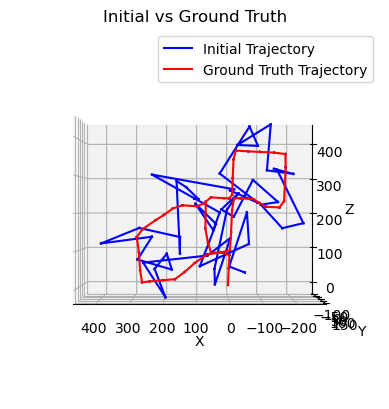

In [109]:
# Create a figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# PLOT INITIAL TRAJECTORY
xs_init, ys_init, zs_init = [], [], []
for key in initial_trajectory.keys():
    pose = initial_trajectory.atPose3(key)
    # Draw the coordinate frame for each pose
    plot_pose3_on_axes(ax, pose=pose, axis_length=0.5)
    # Save the translation for line-plotting
    t = pose.translation()
    xs_init.append(t[0])
    ys_init.append(t[1])
    zs_init.append(t[2])

# Connect initial trajectory poses with a blue line
ax.plot(xs_init, ys_init, zs_init, color='blue', label='Initial Trajectory')

# PLOT GROUND TRUTH TRAJECTORY
xs_gt, ys_gt, zs_gt = [], [], []
for key in ground_truth_trajectory.keys():
    pose = ground_truth_trajectory.atPose3(key)
    # Draw the coordinate frame for each pose
    plot_pose3_on_axes(ax, pose=pose, axis_length=0.5)
    # Save the translation for line-plotting
    t = pose.translation()
    xs_gt.append(t[0])
    ys_gt.append(t[1])
    zs_gt.append(t[2])

# Connect ground truth poses with a red line
ax.plot(xs_gt, ys_gt, zs_gt, color='red', label='Ground Truth Trajectory')

ax.set_title("Initial vs Ground Truth")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
# Top view of the trajectory
ax.view_init(elev=0, azim=90)

plt.show()

## Ex2:

In [110]:
# Step 1: Creates a general factor graph
graph = gtsam.NonlinearFactorGraph()
# Step 2: Define the noise model
s_r = [1e-3, 1e-3, 1e-3]  # Noise for rotation
s_t = [0.1, 0.1, 0.1]  # Noise for translation
noise_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([*s_r, *s_t]))
# step 3: Add factors to the graph
n = len(dposes)
for i in range(n - 1):
    graph.add(
        gtsam.BetweenFactorPose3(gtsam.symbol('x', i), gtsam.symbol('x', i + 1), mat_to_pose3(dposes[i]), noise_model))
graph.add(
    gtsam.BetweenFactorPose3(gtsam.symbol('x', n), gtsam.symbol('x', 0), mat_to_pose3(dposes[n - 1]), noise_model))
# Step 4: Create an initial estimate
prior_factor = gtsam.PriorFactorPose3(gtsam.symbol('x', 0), gtsam.Pose3(), noise_model)
graph.add(prior_factor)

## Ex3: Calculate and display the MAP trajectory esimate

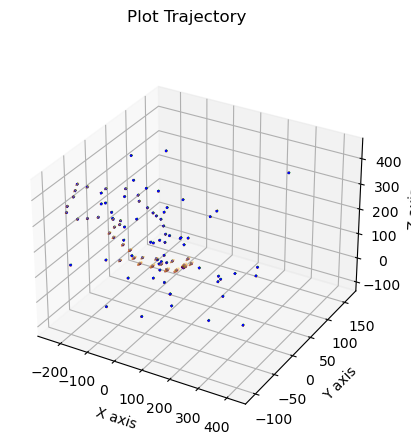

In [111]:
# Step 1: Create an optimizer
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_trajectory)
result = optimizer.optimizeSafely()

# Step 2: Display updated trajectory estimate
marginals = gtsam.Marginals(graph, result)
plot_trajectory(fignum=0, values=result, scale=1,
                marginals=marginals, title='MAP Trajectory Estimate', axis_labels=('X axis', 'Y axis', 'Z axis'))

plot_trajectory(fignum=0, values=initial_trajectory, scale=1)


## Ex4: Loop closure


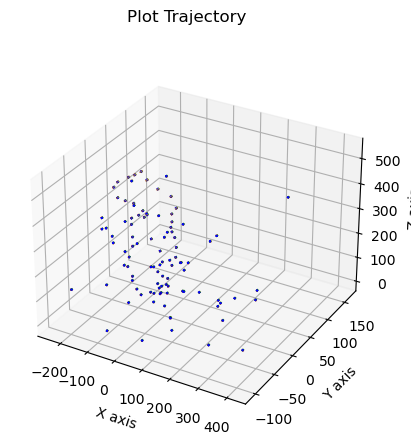

In [114]:
# Step 1: Define observation
R = np.array([[0.330571768, 0.0494690228, -0.942483486], 
              [0.0138000518, 0.998265226, 0.0572371968],
              [0.943679959, -0.0319273223, 0.329315626]])
t = np.array([-24.1616858,-0.0747429903,275.434963])
observ = gtsam.Pose3(gtsam.Rot3(R), gtsam.Point3(t))
# Step 2: Add observation to the graph
graph.add(
    gtsam.BetweenFactorPose3(gtsam.symbol('x', 3), gtsam.symbol('x', 42), observ, noise_model))

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_trajectory)
result_closure = optimizer.optimizeSafely()
marginals = gtsam.Marginals(graph, result_closure)
plot_trajectory(fignum=1, values=result_closure, scale=1, marginals = marginals,
                title='Loop closure', axis_labels=('X axis', 'Y axis', 'Z axis'))
plot_trajectory(fignum=1, values=initial_trajectory, scale=1)



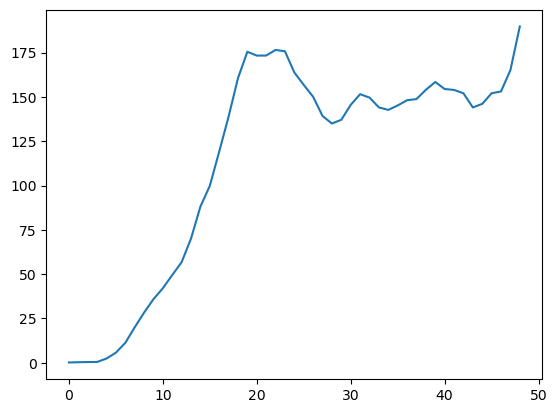

In [115]:
localization_error = []
for i in range(n):
    r_wo = result.atPose3(gtsam.symbol('x', i)).translation()
    r_w = result_closure.atPose3(gtsam.symbol('x', i)).translation()
    localization_error.append(np.linalg.norm(r_wo-r_w))
plt.plot(range(n),localization_error)
plt.show()